In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pylab as plt
from tqdm.notebook import tqdm, trange
import numpy as np
from scipy.spatial.distance import cdist
from mnist import MNIST

from OPTAMI import PrimalDualAccelerated
from run_pd_experiment import run_experiment, cartesian_product, calculate_lipschitz_constant, calculate_M_matrix

In [3]:
n = 784
m = int(np.sqrt(n))

# Primal-Dual Tensor Method

In [5]:
M_matrix = calculate_M_matrix(m)
M_matrix.max()

tensor(2.6669, dtype=torch.float64)

In [6]:
# eps = 1e-3
# gamma = 0.1
eps = 0.02
gamma = eps / 3 / np.log(n)
image_index = 0

In [7]:
M_p = calculate_lipschitz_constant(n, gamma, p_order=3)
M_p

Building matrix A: 100%|█████████████████████| 784/784 [00:02<00:00, 383.18it/s]


tensor(3.6843e+16)

In [8]:
# def ot_softmax():
    # log_B = M_over_gamma + torch.outer(psi, torch.ones(n)) + torch.outer(eta, torch.ones(n))
    # max_log_B = log_B.max()
    # log_B_stable = log_B - max_log_B
    # B_stable = torch.exp(log_b_stable)
    
    # return gamma * (torch.log(B_stable.sum()) + max_log_B - lamb @ b)

In [10]:
%%time
optimizer = run_experiment(M_p, gamma, eps, image_index, max_steps=100)

Step #1, criterion=6.657424764967158, phi=6.664091431633825, f=-0.006666666666666445
lambda=tensor([-1.5917e-07, -1.5917e-07, -1.5917e-07,  ..., -1.5917e-07,
        -1.5917e-07, -1.5917e-07], dtype=torch.float64)
x_hat=tensor([1.2755e-03, 6.0745e-34, 2.8930e-64,  ..., 2.8930e-64, 6.0745e-34,
        1.2755e-03], dtype=torch.float64)

Step #2, criterion=6.657396964604002, phi=6.664063631270669, f=-0.006666666666666425
lambda=tensor([-1.7310e-07, -1.7310e-07, -1.7310e-07,  ..., -1.7310e-07,
        -1.7310e-07, -1.7310e-07], dtype=torch.float64)
x_hat=tensor([1.2755e-03, 6.0745e-34, 2.8930e-64,  ..., 2.8930e-64, 6.0745e-34,
        1.2755e-03], dtype=torch.float64)

Step #3, criterion=6.657339390284144, phi=6.66400605695081, f=-0.006666666666666365
lambda=tensor([-2.0195e-07, -2.0195e-07, -2.0195e-07,  ..., -2.0195e-07,
        -2.0195e-07, -2.0195e-07], dtype=torch.float64)
x_hat=tensor([1.2755e-03, 6.0745e-34, 2.8930e-64,  ..., 2.8930e-64, 6.0745e-34,
        1.2755e-03], dtype=torch.

In [15]:
x = optimizer._calculate_primal_var(optimizer.param_groups[0]['params'][0]).detach().clone()
x

tensor([1.1131e-04, 5.5362e-05, 2.7535e-05,  ..., 2.7535e-05, 5.5362e-05,
        1.1131e-04], dtype=torch.float64)

In [18]:
torch.sum(x == 0)

tensor(0)

## Output test

In [34]:
param = optimizer.param_groups[0]['params'][0]
x = optimizer._calculate_x(param)

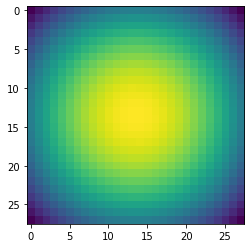

In [46]:
plt.imshow((x.view(n, n) @ torch.ones(n, dtype=float)).view(int(n ** 0.5), int(n ** 0.5)).detach().clone().numpy())

# Primal-Dual gradient method

In [112]:
eps=1e-3
k = 0

epsp = eps/8
p,q = mnist(epsp, p_list[k], q_list[k])
p_ref, q_ref = mnist(0, p_list[k], q_list[k])
            
n = 28 #64 #28
a = p.copy()
b = q.copy()

temp = []
for i in range(n ** 2):
    temp.append([i // n, i % n])
M = cdist(temp, temp)
M = M * M

In [ ]:
def AGMsDR(x_start):
    f = phi_
    f_primal = lambda x: f_(gamma, x)

    mu = 0 #ONLY!
    A = 0.
    tau = 1.
    x, v = x_start.copy(), x_start.copy()
    primal_var = np.zeros_like(K)
    
    start_time = time.perf_counter()
    f_x = None
    t = np.ones(2, np.float64)
    i = 0
    while True:
        y, f_y, grad_f_y, norm2_grad_f_y, x, f_x, B, t[i%2] = agmsdr_iter(i, t[i%2], f_x, x, v)
        #print('\n')
        g = (f_x - f_y)
        a = norm2_grad_f_y + 2*mu*g
        b = 2*mu*A*g + 2*tau*g - mu*tau*(((v - y)*(v - y)).sum())
        c = 2*A*tau*g

        alpha = (-b + np.sqrt(b*b - 4*a*c)) / 2 / a
        
        primal_var = alpha * B + primal_var*A
        A = A + alpha
        
        v = tau*v + mu*alpha*y - alpha * (grad_f_y)
        tau = tau+mu*alpha
        v/=tau
        
        primal_var/=A
        
        #print((C * (B_round(primal_var) - primal_var)).sum(), f_primal(primal_var) + f_x, eps/6)
        if (C * (B_round(primal_var) - primal_var)).sum() <= eps/6 and abs(f_primal(primal_var) + f_x) <= eps/6:
            return time.perf_counter() - start_time
        i-=-1
            
    return np.array(history_f), np.array(history_time)

def agmsdr_iter(i, t, f_x, x, v):
    def check(t, forcereturn=False):
        
        #print(i,': ', t)
        y = v + t * (x-v)
        logB = (K + np.outer(y[:n], one) + np.outer(one, y[n:]))
        max_logB = (logB).max()
        logB_stable = logB - max_logB
        B_stable = np.exp(logB_stable)
        u_hat_stable, v_hat_stable = B_stable.dot(one), B_stable.T.dot(one)
        
        Bs_stable = u_hat_stable.sum()

        f_y = gamma*(-y[:n].dot(p) - y[n:].dot(q) + np.log(Bs_stable) + max_logB)
        grad_f_y = gamma*np.concatenate((-p + u_hat_stable/Bs_stable, -q + v_hat_stable/Bs_stable),0)
        #B_stable/Bs_stable
        if (grad_f_y.dot(v-y) >= 0 and f_x >= f_y) or forcereturn:
            gu, gv = (grad_f_y[:n]**2).sum(), (grad_f_y[n:]**2).sum()
            norm2_grad_f_y = (gu+gv)

            x_new = y.copy()    
            if gu > gv:
                with warnings.catch_warnings():
                    warnings.filterwarnings('error')
                    try:
                        ustep = p/u_hat_stable
                    except Warning as e:
                        u_hat_stable/=u_hat_stable.max()
                        u_hat_stable[u_hat_stable<1e-150] = 1e-150
                        ustep = p/u_hat_stable
                        #print('catchu')
                    
                
                ustep/=ustep.max()
                x_new[:n]+=np.log(ustep)
                Z=ustep[:,None]*B_stable
            else:
                with warnings.catch_warnings():
                    warnings.filterwarnings('error')
                    try:
                        vstep = q/v_hat_stable
                    except Warning as e:
                        v_hat_stable/=v_hat_stable.max()
                        v_hat_stable[v_hat_stable<1e-150] = 1e-150
                        vstep = q/v_hat_stable
                        #print('catchv')

                vstep/=vstep.max()
                x_new[n:]+=np.log(vstep)
                Z=B_stable*vstep[None,:]
            f_x_new=gamma*(np.log(Z.sum())+max_logB-x_new[:n].dot(p)-x_new[n:].dot(q))
            #print(phi_(gamma,x_new) -f_x_new)

            return True, (y, f_y, grad_f_y , norm2_grad_f_y, x_new, f_x_new, B_stable/Bs_stable, t) #f(x_new) can be optimized
        else:
            return False, grad_f_y

    if f_x==None: f_x = phi_(gamma, x) 
    tl=None
    tr=np.float128(t)
    k=0
    while True: #find right endpoint for line search
        is_ok, ret = check(tr)
        if is_ok:
            return ret
        else:
            gr = ret
        if gr.dot(x-v) < 0:
            tl=tr
            tr= 1 + 1e-8 * k**10
        else:
            break
        k-=-1

    
    # small step to the left    
    tmp=max(0, min(tr-(1 - (i+1)/(i+2)), (i+1)/(i+2))) 
    while tl==None: #find left endpoint for line search
        is_ok, ret = check(tmp)
        if is_ok:
            return ret
        else:
            gtmp = ret
        if gtmp.dot(x-v) <= 0:
            tl=tmp
            break
        else:
            tr=tmp
        tmp = 1 - (1-tmp**(4)) 

    
    # search in [tl,tr]
    while True:
        if tr < 0.8 or tl >= 1.:
            tc = tl + (tr-tl)*3/5
        else:
            tc = tl + (tr-tl)*4/5

        is_ok, ret = check(tc, tc==tr or tc==tl)

        if is_ok:
            return ret
        else:
            gc = ret
        if gc.dot(x-v) > 0:
            tr=tc
        else:
            tl=tc

In [ ]:
k=0
for k in range(len(p_list)):
    y_array = np.zeros_like(epslist)
    # if not os.path.isfile('/content/drive/My Drive/colab/'+'!e_'+'agm_'+str(k)+'.npy'):
    i = 0
    for eps in epslist:
        epsp = eps / 8
        p, q = mnist(epsp, p_list[k], q_list[k])
        p_ref, q_ref = mnist(0, p_list[k], q_list[k])
        gamma = eps / 3 / np.log(n)
        K = -C / gamma
        y_array[i] = AGMsDR(x0)
        i -= -1
        # np.save('/content/drive/My Drive/colab/'+'!e_'+'agm_'+str(k)+'.npy', y_array)
    print('agm_', k, ' - done', y_array)

# Test 

In [123]:
n

784

In [53]:
l

60000

In [52]:
#experiments were done for
p_list = [34860, 31226,   239, 37372, 17390]
q_list = [45815, 35817, 43981, 54698, 49947]

In [104]:
eps=1e-3
k=3

epsp = eps
p,q = mnist(epsp, p_list[k], q_list[k])
p_ref, q_ref = mnist(0, p_list[k], q_list[k])

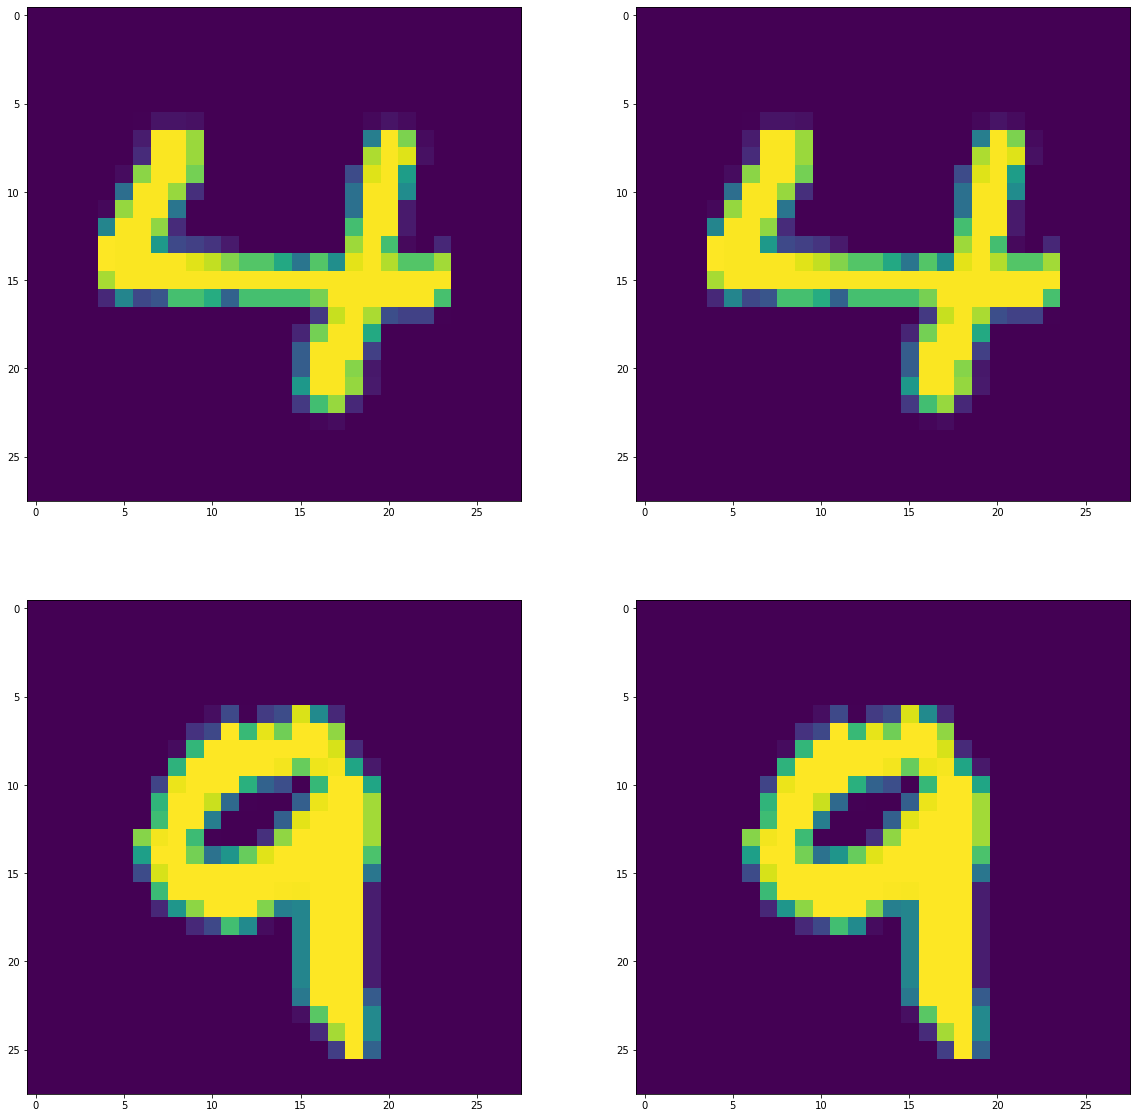

In [105]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes[0, 0].imshow(p_ref.reshape((28, 28)))
axes[0, 1].imshow(p.reshape((28, 28)))
axes[1, 0].imshow(q_ref.reshape((28, 28)))
axes[1, 1].imshow(q.reshape((28, 28)))